In [42]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
  "/kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/velodyne_points/data")
!ls

0000000000.bin	0000000001.bin	0000000002.bin	0000000003.bin


In [ ]:
!pip install open3d

In [5]:
!python -c "import open3d as o3d; print(o3d.__version__)"

0.16.0


In [6]:
import struct
import open3d as o3d
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

#Question A

In [7]:
def convert_kitti_bin_to_pcd(binFilePath):
    size_float = 4
    list_pcd = []
    with open(binFilePath, "rb") as f:
        byte = f.read(size_float * 4)
        while byte:
            x, y, z, intensity = struct.unpack("ffff", byte)
            list_pcd.append([x, y, z])
            byte = f.read(size_float * 4)
    np_pcd = np.asarray(list_pcd)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd)
    return pcd

In [8]:
pcd0 = convert_kitti_bin_to_pcd("0000000000.bin")
# show
print(pcd0)
print(np.asarray(pcd0.points))

PointCloud with 119339 points.
[[75.37000275 12.34799957  2.79200006]
 [75.46499634 12.60700035  2.796     ]
 [75.38200378 12.71500015  2.79399991]
 ...
 [16.78800011 -2.15799999 -7.77600002]
 [16.78899956 -2.10400009 -7.77400017]
 [16.8029995  -2.079      -7.77899981]]


In [9]:
pcd1 = convert_kitti_bin_to_pcd("0000000001.bin")
# show
print(pcd1)
print(np.asarray(pcd1.points))

PointCloud with 118987 points.
[[74.66999817 12.2329998   2.76799989]
 [74.76300049 12.48999977  2.77200007]
 [74.39600372 12.66899967  2.76099992]
 ...
 [ 3.69000006 -1.38900006 -1.722     ]
 [ 3.70900011 -1.38300002 -1.73000002]
 [ 3.70799994 -1.37600005 -1.72800004]]


In [10]:
pcd2 = convert_kitti_bin_to_pcd("0000000002.bin")
# show
print(pcd2)
print(np.asarray(pcd2.points))

PointCloud with 118491 points.
[[74.03500366 12.24800014  2.74699998]
 [74.05000305 12.48999977  2.74799991]
 [73.91600037 12.58699989  2.74499989]
 ...
 [15.06299973 -3.0769999  -7.05299997]
 [15.04100037 -3.023      -7.03800011]
 [15.24800014 -3.03999996 -7.13399982]]


In [11]:
pcd3 = convert_kitti_bin_to_pcd("0000000003.bin")
# show
print(pcd3)
print(np.asarray(pcd3.points))

PointCloud with 118056 points.
[[73.46199799 12.39000034  2.72799993]
 [73.53299713 12.64000034  2.73200011]
 [73.19799805 12.81900024  2.72199988]
 ...
 [14.46100044 -3.         -6.77099991]
 [14.45800018 -2.9519999  -6.76499987]
 [14.69299984 -2.9519999  -6.87200022]]


In [ ]:
o3d.visualization.draw_plotly([pcd0])

In [ ]:
o3d.visualization.draw_plotly([pcd1])

In [ ]:
o3d.visualization.draw_plotly([pcd2])

In [ ]:
o3d.visualization.draw_plotly([pcd3])

In [12]:
lidar_points = np.asarray([pcd0 , pcd1 , pcd2 , pcd3])

#Question B

In [13]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
  "/kitti_sample/2011_09_29/")
!ls

2011_09_29_drive_0026_sync  calib_imu_to_velo.txt
calib_cam_to_cam.txt	    calib_velo_to_cam.txt


In [14]:
def read_calib_file(filepath):
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) == 0: continue
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

In [15]:
def dense_map(Pts, n, m, grid):
    ng = 2 * grid + 1
    
    mX = np.zeros((m,n)) + np.float16("inf")
    mY = np.zeros((m,n)) + np.float16("inf")
    mD = np.zeros((m,n))
    mX[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[0] - np.round(Pts[0])
    mY[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[1] - np.round(Pts[1])
    mD[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[2]
    
    KmX = np.zeros((ng, ng, m - ng, n - ng))
    KmY = np.zeros((ng, ng, m - ng, n - ng))
    KmD = np.zeros((ng, ng, m - ng, n - ng))
    
    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmY[i,j] = mY[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmD[i,j] = mD[i : (m - ng + i), j : (n - ng + j)]
    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])
    
    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s
    
    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid + 1 : -grid, grid + 1 : -grid] = Y/S
    return out

In [17]:
def lidar2image(img , P_rect_xx , frame):
  os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
  "/kitti_sample/2011_09_29/")
  calib_cam_to_cam = read_calib_file("calib_cam_to_cam.txt")
  calib_velo_to_cam = read_calib_file("calib_velo_to_cam.txt")

  R_array = np.asarray(calib_velo_to_cam['R']).reshape(3,3)
  T_array = np.asarray(calib_velo_to_cam['T']).reshape(3,1)

  # Adding column to numpy array
  #P_velo2cam_ref Matrix
  P_velo2cam_ref = np.r_[np.hstack((R_array, T_array)),[[0 , 0 , 0 , 1]]]

  #Calculate for imput frame
  points = np.asarray(frame.points)
  new_points = np.hstack((points, np.ones(points.shape[0]).reshape(points.shape[0] , 1)))

  #Convert lidar to ref
  points_on_ref = np.matmul(P_velo2cam_ref , new_points.T).T

  #Convert ref to rect
  #R_rect_00 Matrix
  R_rect_00 = calib_cam_to_cam["R_rect_00"].reshape(3,3)
  R_rect_00 = np.r_[np.hstack((R_rect_00, [[0] , [0] , [0]])),[[0 , 0 , 0 , 0 ]]]

  points_on_rect = np.matmul(R_rect_00 , points_on_ref.T).T

  #Convert rect to new Cam
  P_rect_02 = calib_cam_to_cam[P_rect_xx].reshape(3,4)
  points_on_cam2 = np.matmul(P_rect_02 , points_on_rect.T).T

  #divide on Z element for Convert points to true values
  main_points_cam2 = []
  for item in points_on_cam2:
    main_points_cam2.append([(item[0]/item[2]) , (item[1] / item[2]) , (item[2] / item[2])])
  main_points_cam2 = np.asarray(main_points_cam2)

  #Remove points out of the image frame
  mask = (main_points_cam2[:,0] >= 0) & (main_points_cam2[:,0] <= img.shape[1]) & (main_points_cam2[:,1] >= 0) & (main_points_cam2[:,1] <= img.shape[0])
  mask = mask & (points_on_rect[:,2] > 2)
  points_2d = main_points_cam2[mask,0:2]

  lidarOnImage = np.concatenate((points_2d, points_on_rect[mask,2].reshape(-1,1)), 1)

  out = dense_map(lidarOnImage.T, img.shape[1], img.shape[0], 1)

  imgfov_pc_pixel = img.copy()

  cmap = plt.cm.get_cmap('hsv', 256)
  cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

  
  for i in range(out.shape[0]):
    for j in range(out.shape[1]):
      if out[i , j] != 0 :
        color = cmap[int(640.0 / out[i , j]), :]
        imgfov_pc_pixel[i , j] = color
  
  return imgfov_pc_pixel , out , lidarOnImage

In [18]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
  "/kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_02/data")
!ls

0000000000.jpg	0000000001.jpg	0000000002.jpg	0000000003.jpg	point_clouds


In [19]:
#Import image
img = cv2.imread("0000000000.jpg")
lidar_on_image , depth_map , points_lidar_image = lidar2image(img, "P_rect_02" , lidar_points[0])

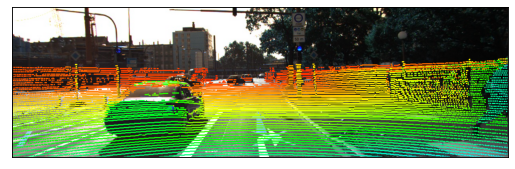

In [23]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(lidar_on_image)
plt.yticks([])
plt.xticks([])
plt.show()

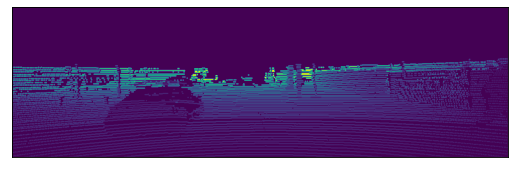

In [25]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(depth_map)
plt.yticks([])
plt.xticks([])
plt.show()

#Question C

In [26]:
grid_x, grid_y = np.mgrid[0:img.shape[1],0:img.shape[0]]

In [27]:
from scipy.interpolate import griddata
grid_z0 = griddata(points_lidar_image[: , 0:2], points_lidar_image[: , 2], (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points_lidar_image[: , 0:2], points_lidar_image[: , 2], (grid_x, grid_y), method='linear')
grid_z2 = griddata(points_lidar_image[: , 0:2], points_lidar_image[: , 2], (grid_x, grid_y), method='cubic')

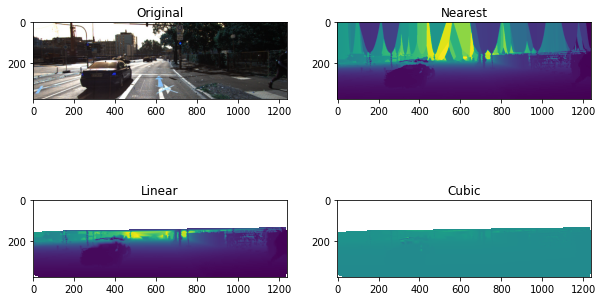

In [35]:
import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(img)
# plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T)
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T)
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T)
plt.title('Cubic')
plt.gcf().set_size_inches(10, 6)
plt.show()

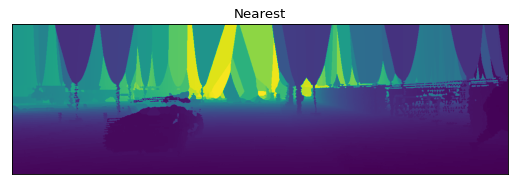

In [38]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(grid_z0.T)
plt.title('Nearest')
plt.yticks([])
plt.xticks([])
plt.show()

#Question D

In [43]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
  "/kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_00/data")
!ls

0000000000.jpg	0000000001.jpg	0000000002.jpg	0000000003.jpg


In [44]:
images0 = []
for item in np.sort(os.listdir()):
  images0.append(cv2.cvtColor(cv2.imread(item), cv2.COLOR_BGR2GRAY))

In [45]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
  "/kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_01/data")
!ls

0000000000.jpg	0000000001.jpg	0000000002.jpg	0000000003.jpg


In [46]:
images1 = []
for item in np.sort(os.listdir()):
  images1.append(cv2.cvtColor(cv2.imread(item), cv2.COLOR_BGR2GRAY))

In [47]:
images0 = np.asarray(images0)
images1 = np.asarray(images1)

In [48]:
images0.shape

(4, 374, 1238)

In [49]:
images1.shape

(4, 374, 1238)

In [50]:
cv2_imshow(images0[0])

KeyError: ignored

<PIL.Image.Image image mode=L size=1238x374 at 0x7FBC334A8D90>

In [51]:
cv2_imshow(images1[0])

KeyError: ignored

<PIL.Image.Image image mode=L size=1238x374 at 0x7FBC33495A90>

In [54]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07")
!ls

Files  kitti_sample


In [61]:
left_RGB = images0[0] # left RGB image
right_RGB = images1[0] # right RGB image
# compute depth map from stereo
depth_maps = []
blocks = [5,11 , 15,25]
for item in range(3,8):
  for i in blocks:
    stereo = cv2.StereoBM_create()
    num_disparities = 16*(item+1)
    stereo.setNumDisparities(num_disparities)
    stereo.setBlockSize(1*(i))
    stereo_depth_map = stereo.compute(left_RGB,right_RGB)
    title = "depth map : disparity =" + str(16*(item+1)) +" Block size =" + str(1*(i))+".jpg"
    cv2.imwrite(title , stereo_depth_map)
    depth_maps.append(stereo_depth_map)

0


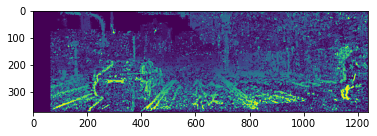

1


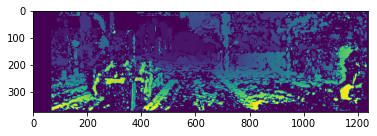

2


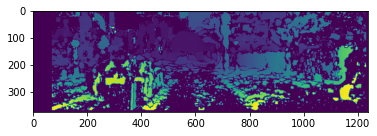

3


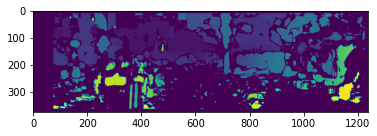

4


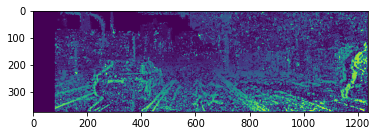

5


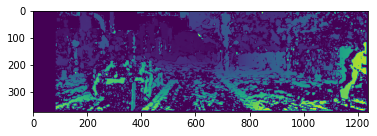

6


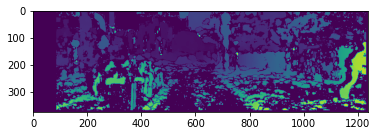

7


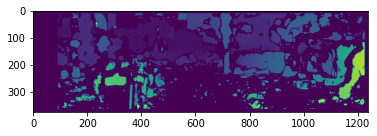

8


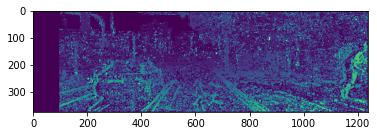

9


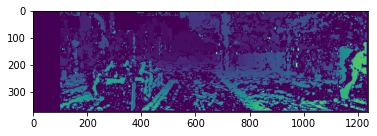

10


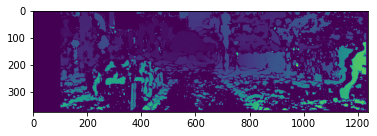

11


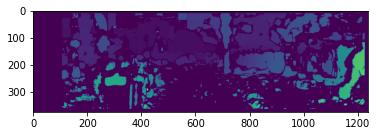

12


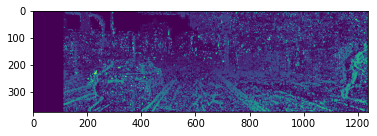

13


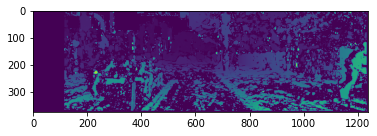

14


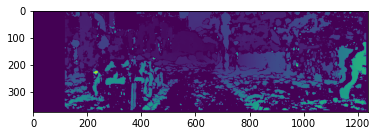

15


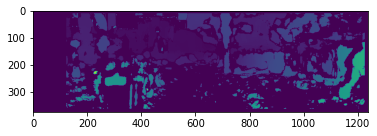

16


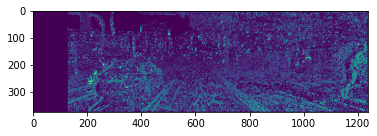

17


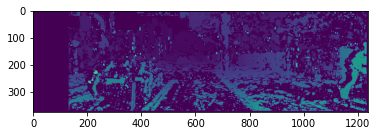

18


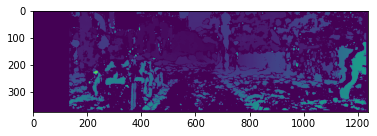

19


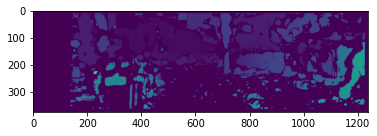

In [62]:
for i , item in enumerate(depth_maps):
  print(i)
  plt.imshow(item)
  plt.show()

#Question E

In [63]:
def img_to_pointcloud(img, depth, K , RT):
    rgb = o3d.geometry.Image(img)
    depth = o3d.geometry.Image(depth)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth, convert_rgb_to_intensity=False)
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(int(cx*2), int(cy*2), fx, fy, cx, cy)
    pc = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic , RT)
    # o3d.visualization.draw_geometries([pc])
    return pc

In [65]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
"/kitti_sample/2011_09_29/")
calib_cam_to_cam = read_calib_file("calib_cam_to_cam.txt")
calib_velo_to_cam = read_calib_file("calib_velo_to_cam.txt")
K = np.asarray(calib_cam_to_cam['K_02']).reshape(3,3)
R = np.asarray(calib_cam_to_cam['R_02']).reshape(3,3)
T = np.asarray(calib_cam_to_cam['T_02']).reshape(3,1)

#RT Matrix
Rt = np.r_[np.hstack((R, T)),[[0 , 0 , 0 , 1]]]

In [66]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07"+
  "/kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_02/data")
!ls

0000000000.jpg	0000000001.jpg	0000000002.jpg	0000000003.jpg	point_clouds


In [67]:
img = cv2.imread("0000000000.jpg")

In [68]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/CV_HW07/Files")
for i , depth in enumerate(depth_maps):
  # blur
  depth = cv2.GaussianBlur(depth, (0,0), sigmaX=1, sigmaY=1)

  pc = img_to_pointcloud(img, depth, K , Rt)
  title = str(i)+".pcd"
  o3d.io.write_point_cloud(title, pc)
  print("Number " , i , ": Finished")

Number  0 : Finished
Number  1 : Finished
Number  2 : Finished
Number  3 : Finished
Number  4 : Finished
Number  5 : Finished
Number  6 : Finished
Number  7 : Finished
Number  8 : Finished
Number  9 : Finished
Number  10 : Finished
Number  11 : Finished
Number  12 : Finished
Number  13 : Finished
Number  14 : Finished
Number  15 : Finished
Number  16 : Finished
Number  17 : Finished
Number  18 : Finished
Number  19 : Finished
